In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run1_limited",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": 2000,
    "num_examples_per_domain_per_label_target": 2000,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1400], examples_per_second: 698.7186, train_label_loss: 2.7673, 


epoch: 1, [batch: 140 / 1400], examples_per_second: 12373.5095, train_label_loss: 2.7089, 


epoch: 1, [batch: 280 / 1400], examples_per_second: 12714.1939, train_label_loss: 2.7274, 


epoch: 1, [batch: 420 / 1400], examples_per_second: 12598.9152, train_label_loss: 2.5429, 


epoch: 1, [batch: 560 / 1400], examples_per_second: 12556.1056, train_label_loss: 2.6076, 


epoch: 1, [batch: 700 / 1400], examples_per_second: 12540.6384, train_label_loss: 2.5662, 


epoch: 1, [batch: 840 / 1400], examples_per_second: 12494.0100, train_label_loss: 2.6221, 


epoch: 1, [batch: 980 / 1400], examples_per_second: 12439.5318, train_label_loss: 2.6382, 


epoch: 1, [batch: 1120 / 1400], examples_per_second: 12523.9050, train_label_loss: 2.5447, 


epoch: 1, [batch: 1260 / 1400], examples_per_second: 12490.2188, train_label_loss: 2.4446, 


epoch: 1, source_val_acc_label: 0.1587, source_val_label_loss: 2.5453, target_val_acc_label: 0.1587, target_val_label_loss: 2.5453, 


New best
epoch: 2, [batch: 1 / 1400], examples_per_second: 60.2383, train_label_loss: 2.4337, 


epoch: 2, [batch: 140 / 1400], examples_per_second: 12352.3564, train_label_loss: 2.3624, 


epoch: 2, [batch: 280 / 1400], examples_per_second: 12530.4819, train_label_loss: 2.2971, 


epoch: 2, [batch: 420 / 1400], examples_per_second: 12648.5745, train_label_loss: 2.2697, 


epoch: 2, [batch: 560 / 1400], examples_per_second: 12563.9574, train_label_loss: 2.3207, 


epoch: 2, [batch: 700 / 1400], examples_per_second: 12463.3439, train_label_loss: 2.2484, 


epoch: 2, [batch: 840 / 1400], examples_per_second: 12345.0973, train_label_loss: 2.2859, 


epoch: 2, [batch: 980 / 1400], examples_per_second: 12342.1053, train_label_loss: 2.3439, 


epoch: 2, [batch: 1120 / 1400], examples_per_second: 12411.3268, train_label_loss: 2.2483, 


epoch: 2, [batch: 1260 / 1400], examples_per_second: 12410.8022, train_label_loss: 2.0763, 


epoch: 2, source_val_acc_label: 0.3217, source_val_label_loss: 2.0784, target_val_acc_label: 0.3217, target_val_label_loss: 2.0784, 


New best
epoch: 3, [batch: 1 / 1400], examples_per_second: 69.1992, train_label_loss: 2.0304, 


epoch: 3, [batch: 140 / 1400], examples_per_second: 12426.9321, train_label_loss: 2.0187, 


epoch: 3, [batch: 280 / 1400], examples_per_second: 12252.4134, train_label_loss: 1.9043, 


epoch: 3, [batch: 420 / 1400], examples_per_second: 11946.0439, train_label_loss: 2.0658, 


epoch: 3, [batch: 560 / 1400], examples_per_second: 11988.9346, train_label_loss: 1.9018, 


epoch: 3, [batch: 700 / 1400], examples_per_second: 12188.0722, train_label_loss: 2.0039, 


epoch: 3, [batch: 840 / 1400], examples_per_second: 12095.3181, train_label_loss: 1.8181, 


epoch: 3, [batch: 980 / 1400], examples_per_second: 12228.1423, train_label_loss: 1.6925, 


epoch: 3, [batch: 1120 / 1400], examples_per_second: 12177.0283, train_label_loss: 1.7908, 


epoch: 3, [batch: 1260 / 1400], examples_per_second: 12368.1724, train_label_loss: 1.6524, 


epoch: 3, source_val_acc_label: 0.4166, source_val_label_loss: 1.7233, target_val_acc_label: 0.4166, target_val_label_loss: 1.7233, 


New best
epoch: 4, [batch: 1 / 1400], examples_per_second: 69.8881, train_label_loss: 1.5212, 


epoch: 4, [batch: 140 / 1400], examples_per_second: 12341.4396, train_label_loss: 1.5438, 


epoch: 4, [batch: 280 / 1400], examples_per_second: 12528.1426, train_label_loss: 1.7313, 


epoch: 4, [batch: 420 / 1400], examples_per_second: 12413.6206, train_label_loss: 1.5730, 


epoch: 4, [batch: 560 / 1400], examples_per_second: 12413.1039, train_label_loss: 1.5470, 


epoch: 4, [batch: 700 / 1400], examples_per_second: 12381.3788, train_label_loss: 1.4051, 


epoch: 4, [batch: 840 / 1400], examples_per_second: 12420.7779, train_label_loss: 1.5000, 


epoch: 4, [batch: 980 / 1400], examples_per_second: 11512.5765, train_label_loss: 1.6851, 


epoch: 4, [batch: 1120 / 1400], examples_per_second: 12136.1866, train_label_loss: 1.4009, 


epoch: 4, [batch: 1260 / 1400], examples_per_second: 12287.5246, train_label_loss: 1.3768, 


epoch: 4, source_val_acc_label: 0.4561, source_val_label_loss: 1.5717, target_val_acc_label: 0.4561, target_val_label_loss: 1.5717, 


New best
epoch: 5, [batch: 1 / 1400], examples_per_second: 67.2627, train_label_loss: 1.1763, 


epoch: 5, [batch: 140 / 1400], examples_per_second: 12247.9359, train_label_loss: 1.2965, 


epoch: 5, [batch: 280 / 1400], examples_per_second: 12369.5321, train_label_loss: 1.2349, 


epoch: 5, [batch: 420 / 1400], examples_per_second: 12378.2387, train_label_loss: 1.3203, 


epoch: 5, [batch: 560 / 1400], examples_per_second: 12451.0572, train_label_loss: 1.1654, 


epoch: 5, [batch: 700 / 1400], examples_per_second: 12466.2730, train_label_loss: 1.2428, 


epoch: 5, [batch: 840 / 1400], examples_per_second: 12330.2384, train_label_loss: 1.1925, 


epoch: 5, [batch: 980 / 1400], examples_per_second: 10791.1365, train_label_loss: 1.2894, 


epoch: 5, [batch: 1120 / 1400], examples_per_second: 10586.8013, train_label_loss: 1.2839, 


epoch: 5, [batch: 1260 / 1400], examples_per_second: 10694.1512, train_label_loss: 1.5960, 


epoch: 5, source_val_acc_label: 0.4889, source_val_label_loss: 1.4332, target_val_acc_label: 0.4889, target_val_label_loss: 1.4332, 


New best
epoch: 6, [batch: 1 / 1400], examples_per_second: 57.1218, train_label_loss: 1.0517, 


epoch: 6, [batch: 140 / 1400], examples_per_second: 10629.6519, train_label_loss: 0.8233, 


epoch: 6, [batch: 280 / 1400], examples_per_second: 10696.8984, train_label_loss: 0.9605, 


epoch: 6, [batch: 420 / 1400], examples_per_second: 10677.3156, train_label_loss: 0.9645, 


epoch: 6, [batch: 560 / 1400], examples_per_second: 10659.9372, train_label_loss: 1.1202, 


epoch: 6, [batch: 700 / 1400], examples_per_second: 10689.4258, train_label_loss: 1.0955, 


epoch: 6, [batch: 840 / 1400], examples_per_second: 10696.8923, train_label_loss: 1.0418, 


epoch: 6, [batch: 980 / 1400], examples_per_second: 10686.2540, train_label_loss: 0.8750, 


epoch: 6, [batch: 1120 / 1400], examples_per_second: 10592.3813, train_label_loss: 1.0710, 


epoch: 6, [batch: 1260 / 1400], examples_per_second: 10703.4989, train_label_loss: 1.0456, 


epoch: 6, source_val_acc_label: 0.4925, source_val_label_loss: 1.4331, target_val_acc_label: 0.4925, target_val_label_loss: 1.4331, 


New best
epoch: 7, [batch: 1 / 1400], examples_per_second: 56.9243, train_label_loss: 0.7279, 


epoch: 7, [batch: 140 / 1400], examples_per_second: 10616.6240, train_label_loss: 0.6704, 


epoch: 7, [batch: 280 / 1400], examples_per_second: 10681.0710, train_label_loss: 0.7313, 


epoch: 7, [batch: 420 / 1400], examples_per_second: 10622.2653, train_label_loss: 0.7228, 


epoch: 7, [batch: 560 / 1400], examples_per_second: 10693.0102, train_label_loss: 0.8905, 


epoch: 7, [batch: 700 / 1400], examples_per_second: 10732.1380, train_label_loss: 0.6576, 


epoch: 7, [batch: 840 / 1400], examples_per_second: 10689.4623, train_label_loss: 0.7224, 


epoch: 7, [batch: 980 / 1400], examples_per_second: 10695.4402, train_label_loss: 1.0592, 


epoch: 7, [batch: 1120 / 1400], examples_per_second: 11006.4666, train_label_loss: 0.7931, 


epoch: 7, [batch: 1260 / 1400], examples_per_second: 11761.6312, train_label_loss: 0.8552, 


epoch: 7, source_val_acc_label: 0.4930, source_val_label_loss: 1.4949, target_val_acc_label: 0.4930, target_val_label_loss: 1.4949, 


New best
epoch: 8, [batch: 1 / 1400], examples_per_second: 64.3067, train_label_loss: 0.6242, 


epoch: 8, [batch: 140 / 1400], examples_per_second: 11679.2150, train_label_loss: 0.5762, 


epoch: 8, [batch: 280 / 1400], examples_per_second: 11732.5277, train_label_loss: 0.5410, 


epoch: 8, [batch: 420 / 1400], examples_per_second: 11731.9563, train_label_loss: 0.6747, 


epoch: 8, [batch: 560 / 1400], examples_per_second: 11682.0015, train_label_loss: 0.4691, 


epoch: 8, [batch: 700 / 1400], examples_per_second: 11723.5771, train_label_loss: 0.6523, 


epoch: 8, [batch: 840 / 1400], examples_per_second: 11639.4778, train_label_loss: 0.4494, 


epoch: 8, [batch: 980 / 1400], examples_per_second: 11784.6050, train_label_loss: 0.6496, 


epoch: 8, [batch: 1120 / 1400], examples_per_second: 11636.8467, train_label_loss: 0.5476, 


epoch: 8, [batch: 1260 / 1400], examples_per_second: 11693.5460, train_label_loss: 0.6462, 


epoch: 8, source_val_acc_label: 0.4854, source_val_label_loss: 1.5853, target_val_acc_label: 0.4854, target_val_label_loss: 1.5853, 


epoch: 9, [batch: 1 / 1400], examples_per_second: 65.2099, train_label_loss: 0.3830, 


epoch: 9, [batch: 140 / 1400], examples_per_second: 11666.6912, train_label_loss: 0.6943, 


epoch: 9, [batch: 280 / 1400], examples_per_second: 11772.6293, train_label_loss: 0.5479, 


epoch: 9, [batch: 420 / 1400], examples_per_second: 11780.3143, train_label_loss: 0.4995, 


epoch: 9, [batch: 560 / 1400], examples_per_second: 11716.3311, train_label_loss: 0.5501, 


epoch: 9, [batch: 700 / 1400], examples_per_second: 11702.9956, train_label_loss: 0.5012, 


epoch: 9, [batch: 840 / 1400], examples_per_second: 11761.4674, train_label_loss: 0.4455, 


epoch: 9, [batch: 980 / 1400], examples_per_second: 11695.3838, train_label_loss: 0.5162, 


epoch: 9, [batch: 1120 / 1400], examples_per_second: 11765.2415, train_label_loss: 0.3961, 


epoch: 9, [batch: 1260 / 1400], examples_per_second: 11793.5084, train_label_loss: 0.5158, 


epoch: 9, source_val_acc_label: 0.4723, source_val_label_loss: 1.6910, target_val_acc_label: 0.4723, target_val_label_loss: 1.6910, 


epoch: 10, [batch: 1 / 1400], examples_per_second: 65.7068, train_label_loss: 0.3154, 


epoch: 10, [batch: 140 / 1400], examples_per_second: 11651.9814, train_label_loss: 0.2607, 


epoch: 10, [batch: 280 / 1400], examples_per_second: 11736.6589, train_label_loss: 0.2985, 


epoch: 10, [batch: 420 / 1400], examples_per_second: 11757.3701, train_label_loss: 0.5133, 


epoch: 10, [batch: 560 / 1400], examples_per_second: 11713.1888, train_label_loss: 0.3192, 


epoch: 10, [batch: 700 / 1400], examples_per_second: 11736.3895, train_label_loss: 0.3515, 


epoch: 10, [batch: 840 / 1400], examples_per_second: 11698.2835, train_label_loss: 0.3176, 


epoch: 10, [batch: 980 / 1400], examples_per_second: 11705.5363, train_label_loss: 0.8149, 


epoch: 10, [batch: 1120 / 1400], examples_per_second: 11745.0771, train_label_loss: 0.5020, 


epoch: 10, [batch: 1260 / 1400], examples_per_second: 11676.6369, train_label_loss: 0.3955, 


epoch: 10, source_val_acc_label: 0.4725, source_val_label_loss: 1.7751, target_val_acc_label: 0.4725, target_val_label_loss: 1.7751, 


epoch: 11, [batch: 1 / 1400], examples_per_second: 64.9449, train_label_loss: 0.2775, 


epoch: 11, [batch: 140 / 1400], examples_per_second: 11682.8737, train_label_loss: 0.2172, 


epoch: 11, [batch: 280 / 1400], examples_per_second: 11789.0541, train_label_loss: 0.4873, 


epoch: 11, [batch: 420 / 1400], examples_per_second: 11715.9056, train_label_loss: 0.2597, 


epoch: 11, [batch: 560 / 1400], examples_per_second: 11685.4905, train_label_loss: 0.3482, 


epoch: 11, [batch: 700 / 1400], examples_per_second: 11633.0213, train_label_loss: 0.1759, 


epoch: 11, [batch: 840 / 1400], examples_per_second: 11757.9200, train_label_loss: 0.3748, 


epoch: 11, [batch: 980 / 1400], examples_per_second: 11672.3791, train_label_loss: 0.4024, 


epoch: 11, [batch: 1120 / 1400], examples_per_second: 12322.3911, train_label_loss: 0.3659, 


epoch: 11, [batch: 1260 / 1400], examples_per_second: 12060.8598, train_label_loss: 0.3827, 


epoch: 11, source_val_acc_label: 0.4522, source_val_label_loss: 1.8958, target_val_acc_label: 0.4522, target_val_label_loss: 1.8958, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

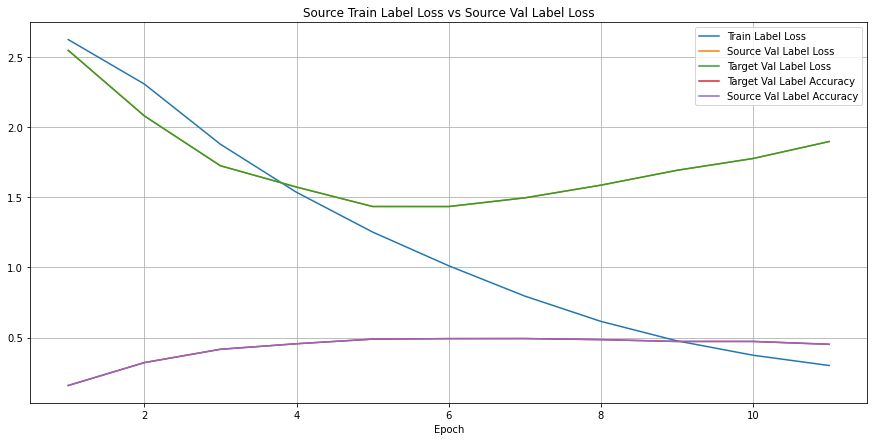

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

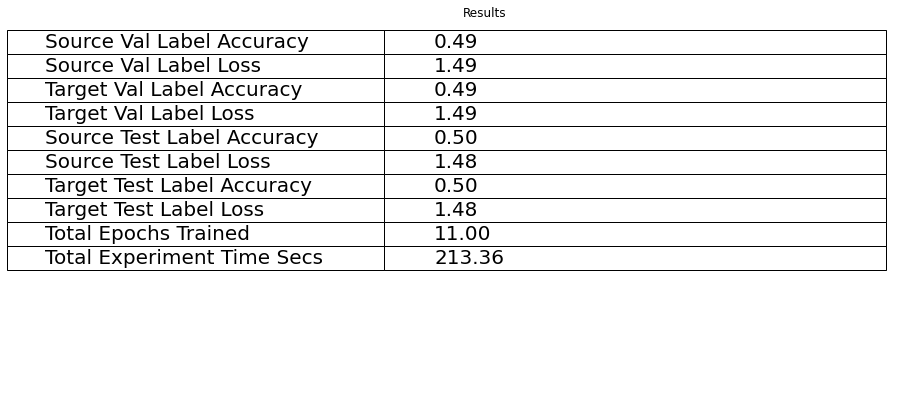

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

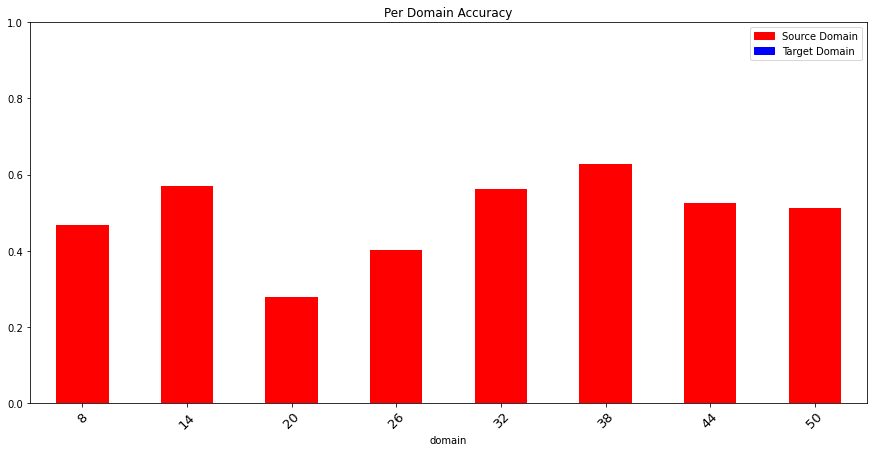

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.49856770833333336 Target Test Label Accuracy: 0.49856770833333336
Source Val Label Accuracy: 0.49296875 Target Val Label Accuracy: 0.49296875


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run1_limited", "parameters": {"experiment_name": "cnn_2:oracle.run1_limited", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": 2000, "num_examples_per_domain_per_label_target": 2000, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 2